<a href="https://colab.research.google.com/github/Droslj/scATAC-seq-complete-/blob/Google-colab/scATAC_seq_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

scATAC seq, based on scATAC seq processing Galaxy tutorials (scATAC preprocessing (2), Standard scATAC seq processing pipeline (1) )
AD Objects created in Galaxy using customized Galaxy WF with Snapatac2 and imported
(1) https://usegalaxy.eu/training-material/topics/single-cell/tutorials/scatac-preprocessing-tenx/tutorial.html#mapping-reads-to-a-reference-genome, (2) https://usegalaxy.eu/training-material/topics/single-cell/tutorials/scatac-standard-processing-snapatac2/tutorial.html
Data taken from the following NCBI study:
Metabolic adaptation pilots the differentiation of human hematopoietic cells (https://www.ncbi.nlm.nih.gov/bioproject/PRJNA1015713)
Import Anndata objects for two biological replicates, SRR26046013 (cells treated with AOA inhibitor) and SRR26046019 (untreated cells)
Perform following steps:
(1) Import matrices
(2) Compute fragment size distribution
(3) Compute TSS enrichment
(4) Filter cell counts based on TSSe
(5) Create cell by bin matrix based on 500 bp wide bins accross the whole genome
(6) Perform feature selection
(7) Perform Doublet removal
(8) Perform Dim reduction (spectral)
(9) Perform Clustering (neighborhood, UMAP, leiden)
(10) Create a cell by gene matrix
(11) Concatenate matrices using Inner join
(12) Remove batch effects

In [1]:
!pip install -q condacolab

In [2]:
import condacolab

In [3]:
condacolab.install()

✨🍰✨ Everything looks OK!


In [4]:
!conda --version

conda 23.11.0


In [5]:
!which conda

/usr/local/bin/conda


In [6]:
!conda config --add channels conda-forge

In [7]:
!conda config --add channels bioconda

In [8]:
!pip install snapatac2 -q

In [9]:
!pip show snapatac2

Name: snapatac2
Version: 2.8.0
Summary: SnapATAC2: Single-cell epigenomics analysis pipeline
Home-page: https://github.com/
Author: Kai Zhang <kai@kzhang.org>
Author-email: Kai Zhang <zhangkai33@westlake.edu.cn>
License: MIT
Location: /usr/local/lib/python3.10/site-packages
Requires: anndata, igraph, kaleido, macs3, multiprocess, natsort, numpy, pandas, plotly, polars, pooch, pyarrow, pyfaidx, rustworkx, scikit-learn, scipy, tqdm, typeguard
Required-by: 


In [10]:
import snapatac2 as snap

In [11]:
!pip install umap-learn



In [12]:
import umap.umap_ as umap


In [13]:
from umap import UMAP

In [14]:
!pip install scanpy -q

In [15]:
import scanpy as sc

In [16]:
pip show scanpy

Name: scanpy
Version: 1.10.4
Summary: Single-Cell Analysis in Python.
Home-page: 
Author: Alex Wolf, Philipp Angerer, Fidel Ramirez, Isaac Virshup, Sergei Rybakov, Gokcen Eraslan, Tom White, Malte Luecken, Davide Cittaro, Tobias Callies, Marius Lange, Andrés R. Muñoz-Rojas
Author-email: 
License: 
Location: /usr/local/lib/python3.10/site-packages
Requires: anndata, h5py, joblib, legacy-api-wrap, matplotlib, natsort, networkx, numba, numpy, packaging, pandas, patsy, pynndescent, scikit-learn, scipy, seaborn, session-info, statsmodels, tqdm, umap-learn
Required-by: 


In [17]:
import numpy as np

In [18]:
import anndata as ad

In [19]:
!pip install diffxpy -q

In [20]:
import diffxpy.api as de

In [21]:
import matplotlib.pyplot as plt

In [22]:
import seaborn as sns

In [23]:
import plotly.subplots as sp
import plotly.graph_objects as go

In [24]:
from scipy import stats

# Import reads from google drive, three samples treated with energy metabolism inhibitors and one untreated

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
#Load AD matrix from google drive, PCA and Batch corrected
adata_concat = sc.read_h5ad('/content/drive/MyDrive/Colab Notebooks/MTXmerged_PCA_BC.h5ad')

/usr/local/lib/python3.10/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Plot the 'obsm' before and after batch effect removal (PC1 vs PC2)

In [27]:
#Extract data sets
x_before = adata_concat.obsm['X_pca'][:, 0]
y_before = adata_concat.obsm['X_pca'][:, 1]

x_after = adata_concat.obsm['X_pca_harmony'][:, 0]
y_after = adata_concat.obsm['X_pca_harmony'][:, 1]
batch_labels = adata_concat.obs['Treatment']


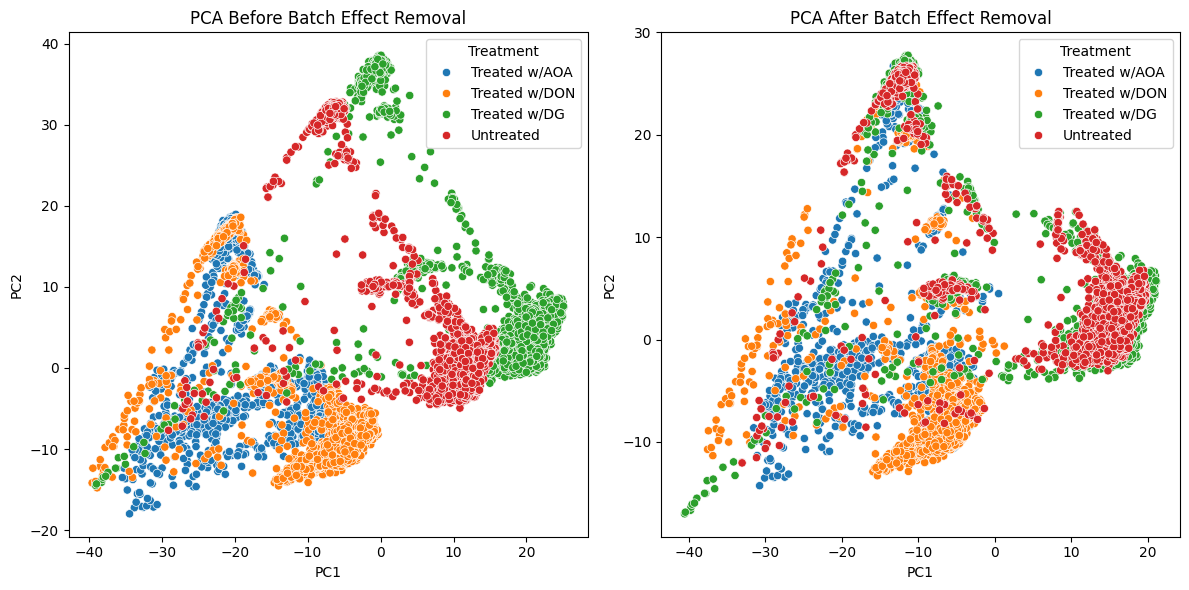

In [28]:
#Define figure
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
#Plot before batch effect removal

sns.scatterplot(x=x_before, y=y_before, hue=batch_labels)
plt.title('PCA Before Batch Effect Removal')
plt.xlabel('PC1')
plt.ylabel('PC2')

#Plot PCA after batch effect removal

plt.subplot(1, 2, 2)
sns.scatterplot(x=x_after, y=y_after, hue=batch_labels)
plt.title('PCA After Batch Effect Removal')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.tight_layout()
plt.show()

In [29]:
#from shutil import copyfile
#copyfile('adata_concat.h5ad', '/content/drive/MyDrive/Colab Notebooks/adata_concat.h5ad')

In [30]:
adata_concat

AnnData object with n_obs × n_vars = 21361 × 53017
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden', 'Treatment'
    uns: 'pca'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'

# Differential accesibility analysis

In [31]:
# Perform differential accessibility testing with Wilcoxon rank-sum test
sc.tl.rank_genes_groups(adata_concat, 'Treatment', method='wilcoxon')

In [32]:
# Access results in `adata_concat.uns['rank_genes_groups']`
# For example, to get the top differentially accessible regions:
top_dars = sc.get.rank_genes_groups_df(adata_concat, group='Treated w/AOA', pval_cutoff=0.05)

In [33]:
top_dars

,names,scores,logfoldchanges,pvals,pvals_adj
0,LINC01686,11.140080,0.387329,8.004735e-29,4.263054e-28
1,SATB1,10.738822,0.262134,6.689235e-27,3.368251e-26
2,LRRN3,10.288052,0.659100,7.977435e-25,3.778946e-24
3,LEF1,10.168393,0.363969,2.743984e-24,1.277466e-23
4,CD3D,9.889269,1.128489,4.633991e-23,2.076932e-22
...,...,...,...,...,...
27797,CNTNAP2,-47.828995,-1.124444,0.000000e+00,0.000000e+00
27798,CDH23,-47.958527,-0.664805,0.000000e+00,0.000000e+00
27799,MSI2,-48.331894,-0.729379,0.000000e+00,0.000000e+00
27800,RBFOX1,-49.328617,-1.324195,0.000000e+00,0.000000e+00


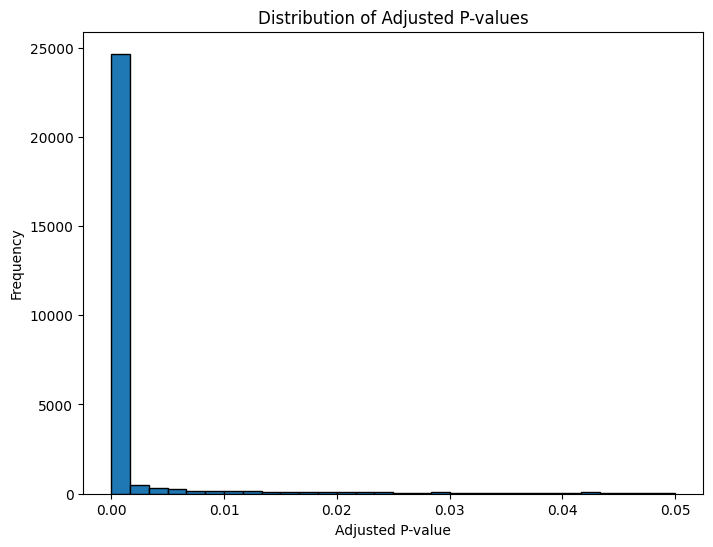

In [34]:
#Distribution of Adjusted P-values

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.hist(top_dars['pvals_adj'], bins=30, edgecolor='black')
plt.title('Distribution of Adjusted P-values')
plt.xlabel('Adjusted P-value')
_ = plt.ylabel('Frequency')

In [35]:
# Sort by adjusted p-value in ascending order (most significant first)
top_dars_sorted = top_dars.sort_values(by='pvals_adj')

# Select the top 10 rows
top_10_dars = top_dars_sorted.head(10)
bottom_10_dars = top_dars_sorted.tail(10)

In [36]:
# Display the top 10 DARs
print(top_10_dars)

                 names     scores  logfoldchanges  pvals  pvals_adj
27801            ZMIZ1 -52.757572       -0.801663    0.0        0.0
27720        IL12A-AS1 -39.203812       -0.853888    0.0        0.0
27721  ENSG00000283563 -39.211956       -0.724741    0.0        0.0
27722            KDM4B -39.223949       -0.668567    0.0        0.0
27723           INPP5A -39.293507       -0.600778    0.0        0.0
27724  ENSG00000258344 -39.321419       -0.604507    0.0        0.0
27725             SUFU -39.419426       -0.636987    0.0        0.0
27726  ENSG00000230773 -39.501812       -0.656824    0.0        0.0
27727             DLC1 -39.522858       -0.956882    0.0        0.0
27728            RBMS3 -39.539345       -0.894024    0.0        0.0


In [37]:
print(bottom_10_dars)

               names    scores  logfoldchanges     pvals  pvals_adj
289           NANOS2 -2.226390       -1.051699  0.025988   0.049574
288  ENSG00000289068 -2.226055       -0.639451  0.026010   0.049615
287           MRGPRG -2.225368       -1.574157  0.026057   0.049701
286        RNU6-163P -2.225322       -0.660606  0.026060   0.049705
285        LINC02387 -2.225267       -0.825357  0.026063   0.049710
284           PPP3CC -2.225226       -0.065779  0.026066   0.049714
283        RPL21P126 -2.225075       -1.059356  0.026076   0.049731
282         C6orf163 -2.224730       -0.845233  0.026099   0.049774
281           NDUFA1 -2.223986       -0.120385  0.026149   0.049867
280  ENSG00000224810 -2.222990       -0.678497  0.026217   0.049994


/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


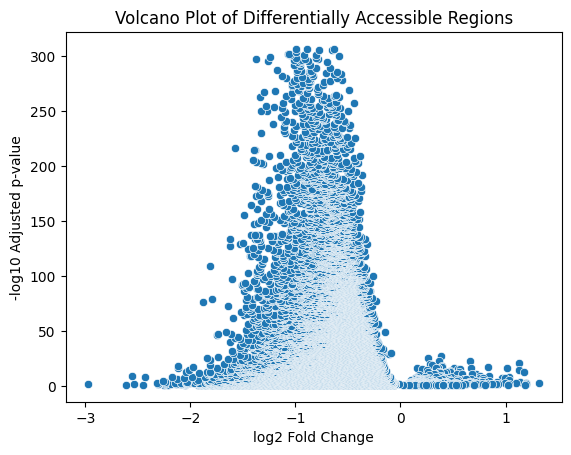

In [38]:
# Create scatterplot of differential accessibility results
sns.scatterplot(x=top_dars['logfoldchanges'], y=-np.log10(top_dars['pvals_adj']))
plt.xlabel('log2 Fold Change')
plt.ylabel('-log10 Adjusted p-value')
plt.title('Volcano Plot of Differentially Accessible Regions')
plt.show()

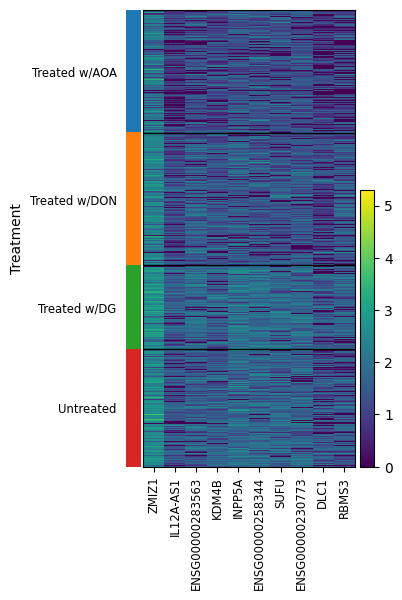

In [39]:
#Heatmap of top 10 differentially most expressed genes
sc.pl.heatmap(adata_concat, top_10_dars['names'].tolist(), groupby='Treatment', cmap='viridis')

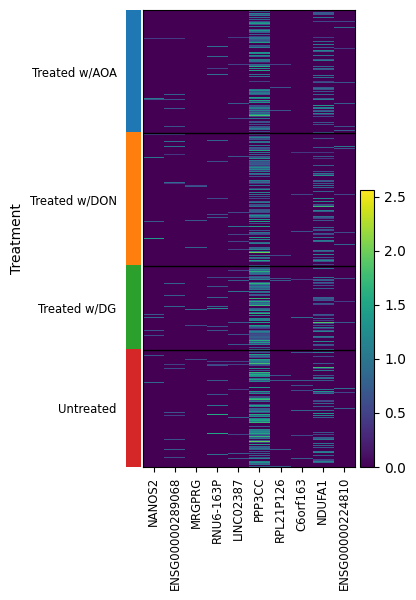

In [40]:
#Heatmap of top 10 differentially lowest expressed genes
sc.pl.heatmap(adata_concat, bottom_10_dars['names'].tolist(), groupby='Treatment', cmap='viridis')

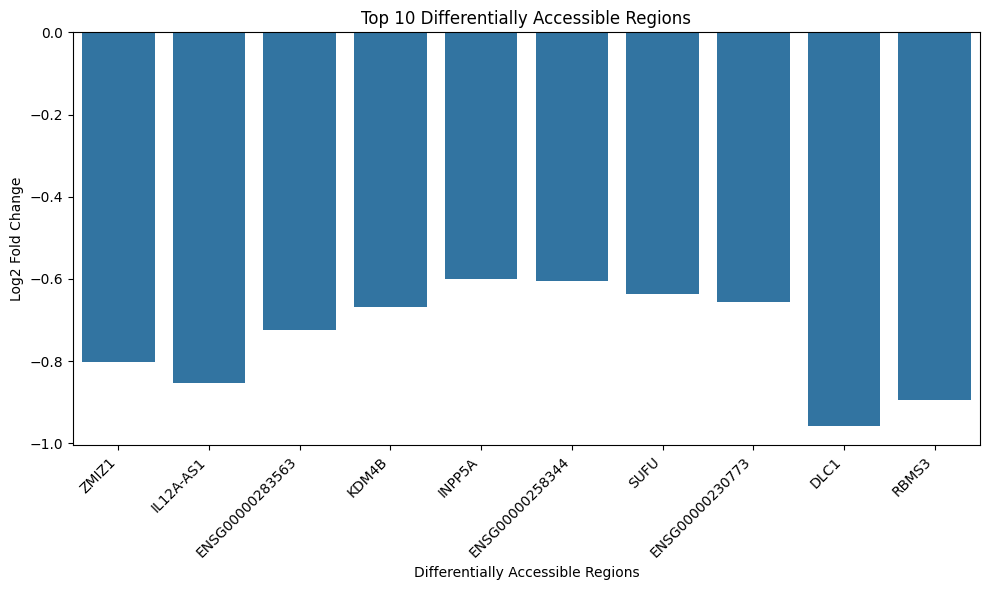

In [41]:
# Create a bar plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
sns.barplot(x=top_10_dars['names'].tolist(), y=top_10_dars['logfoldchanges'])
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.xlabel('Differentially Accessible Regions')
plt.ylabel('Log2 Fold Change')
plt.title('Top 10 Differentially Accessible Regions')
plt.tight_layout()
plt.show()

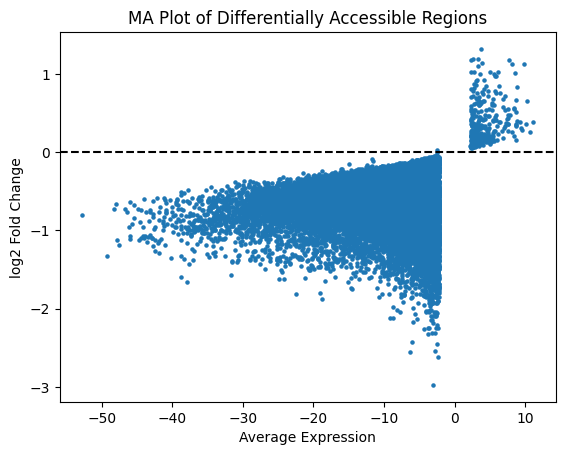

In [42]:
import matplotlib.pyplot as plt

# Assuming 'res_df' is your DataFrame of differential accessibility results
plt.scatter(top_dars['scores'], top_dars['logfoldchanges'], s=5)
plt.xlabel('Average Expression')
plt.ylabel('log2 Fold Change')
plt.title('MA Plot of Differentially Accessible Regions')
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

In [43]:
adata_concat.var_names

Index(['DDX11L1', 'WASH7P', 'ENSG00000238009', 'ENSG00000239945', 'DDX11L17',
       'WASH9P', 'ENSG00000228463', 'ENSG00000286448', 'U6', 'ENSG00000230021',
       ...
       'MT-ND4', 'MT-TH', 'MT-TS2', 'MT-TL2', 'MT-ND5', 'MT-ND6', 'MT-TE',
       'MT-CYB', 'MT-TT', 'MT-TP'],
      dtype='object', length=53017)

Generating violin plots:   0%|          | 0/10 [00:00<?, ?it/s]

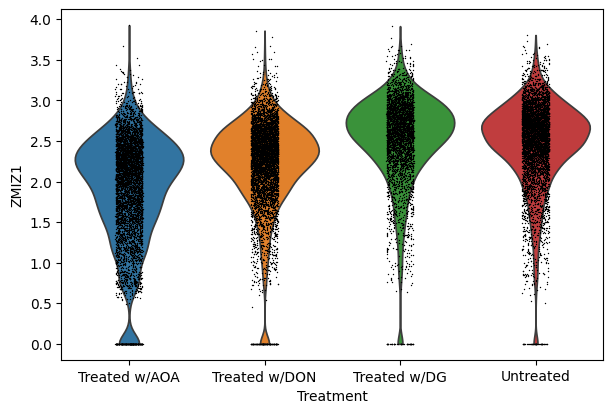

Generating violin plots:  10%|█         | 1/10 [00:01<00:11,  1.32s/it]

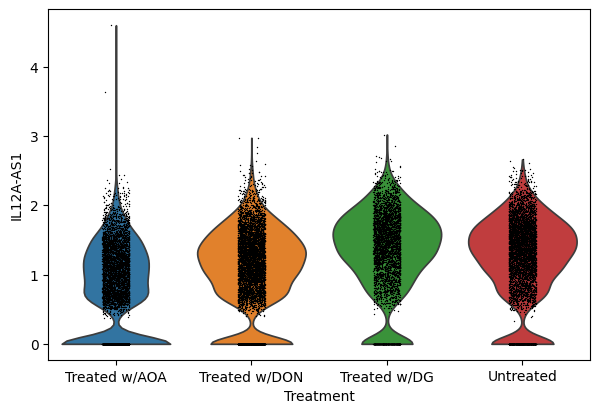

Generating violin plots:  20%|██        | 2/10 [00:02<00:09,  1.23s/it]

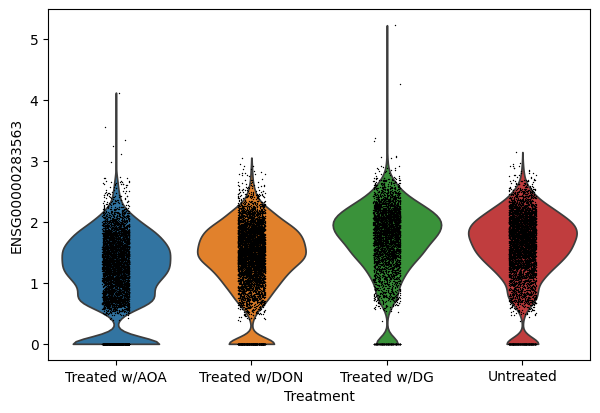

Generating violin plots:  30%|███       | 3/10 [00:03<00:08,  1.18s/it]

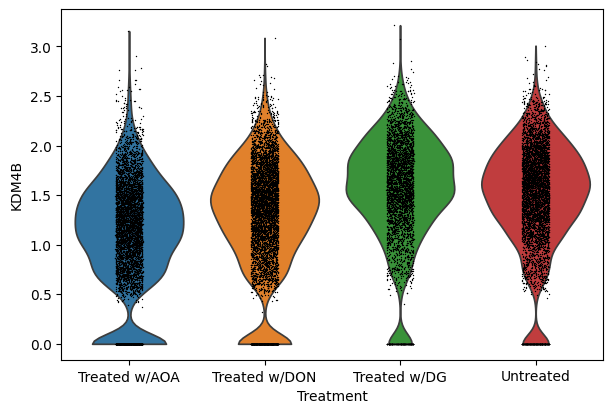

Generating violin plots:  40%|████      | 4/10 [00:04<00:06,  1.16s/it]

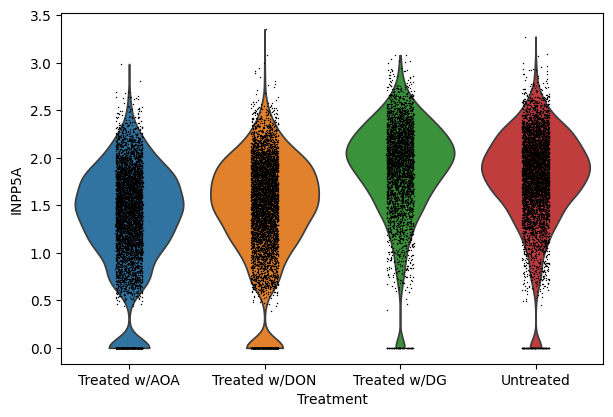

Generating violin plots:  50%|█████     | 5/10 [00:05<00:05,  1.15s/it]

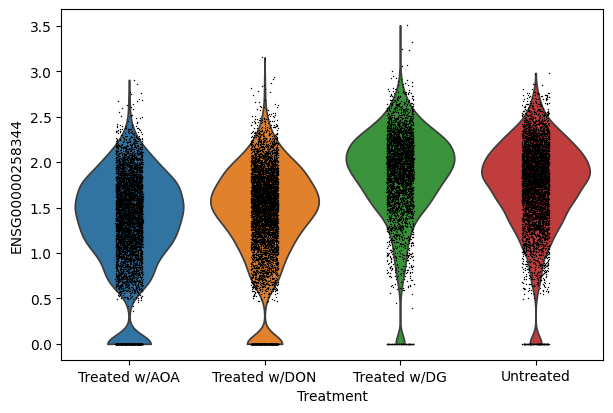

Generating violin plots:  60%|██████    | 6/10 [00:07<00:04,  1.15s/it]

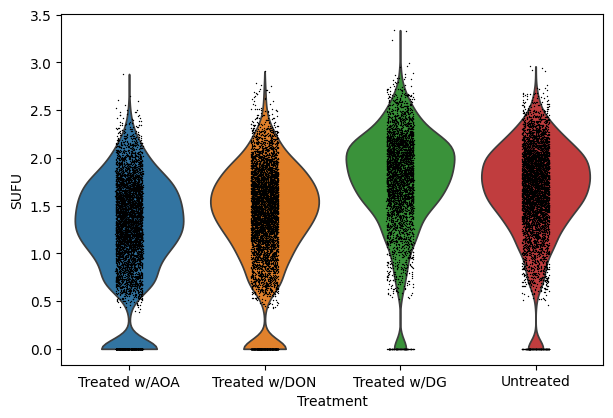

Generating violin plots:  70%|███████   | 7/10 [00:08<00:03,  1.16s/it]

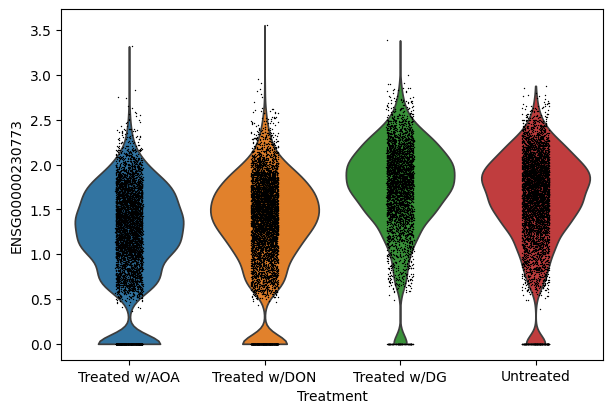

Generating violin plots:  80%|████████  | 8/10 [00:09<00:02,  1.16s/it]

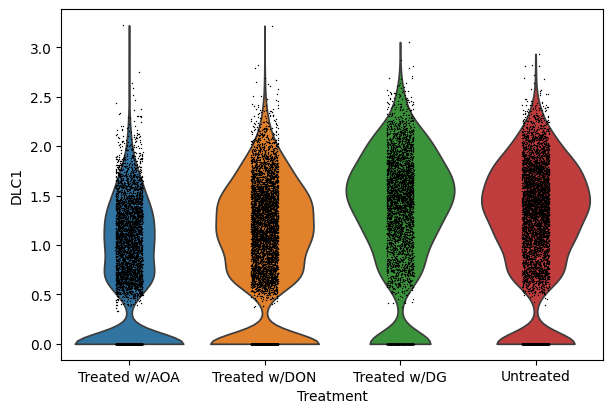

Generating violin plots:  90%|█████████ | 9/10 [00:10<00:01,  1.15s/it]

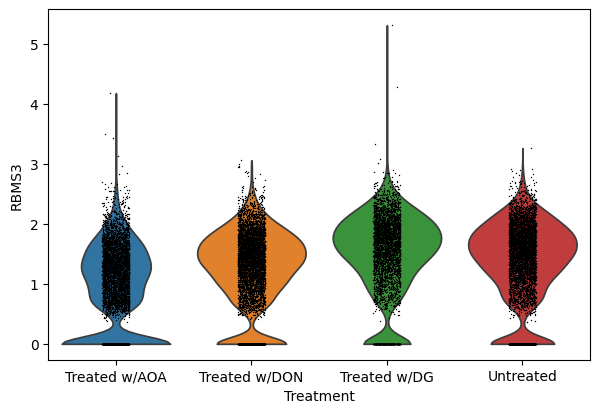

Generating violin plots: 100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


In [44]:
from tqdm import tqdm

for gene in tqdm(top_10_dars['names'].tolist(), desc="Generating violin plots"):
    sc.pl.violin(adata_concat, [gene], groupby='Treatment')

# Differential accessibility analysis using diffxpy

In [45]:
import os

# Get the current working directory
current_directory = os.getcwd()

# Print the current working directory
print(f"Current working directory: {current_directory}")

Current working directory: /content


In [46]:
#numpy type aliases
np.float = float
np.int = int   #module 'numpy' has no attribute 'int'
np.object = object    #module 'numpy' has no attribute 'object'
np.bool = bool    #module 'numpy' has no attribute 'bool'

# Process data in batches of 1000

In [51]:
import scipy.sparse as sparse

In [ ]:
# Split genes into batches of 1000
n_genes = adata_concat.var.shape[0]
batch_size = 1000
n_batches = int(np.ceil(n_genes / batch_size))

test_batch_total = []

# Iterate through batches
for i in range(n_batches):
    start = i * batch_size
    end = min((i + 1) * batch_size, n_genes)

    # Subset the data for the current batch
    adata_batch = adata_concat[:, start:end]

    # Convert the data type to a type with a defined size, if necessary
    # Check if the data type is sparse and convert to a dense type with a defined size
    if adata_batch.X.dtype.itemsize == 0:
        adata_batch.X = adata_batch.X.astype(np.float32)  # Or np.float64 if needed
    elif isinstance(adata_batch.X, (sparse.csr_matrix, sparse.csc_matrix)):
        adata_batch.X = adata_batch.X.toarray().astype(np.float32) # Or np.float64 if needed

    # Perform the Wald test on the batch
    test_batch = de.test.wald(
        data=adata_batch,
        formula_loc="~ 1 + Treatment",
        factor_loc_totest="Treatment"
    )

    # Combine results (e.g., append to a list)
    test_batch_total.append(test_batch)

training location model: False
training scale model: True
iter   0: ll=1340114264.338309
iter   1: ll=1340114264.338309, converged: 0.00% (loc: 100.00%, scale update: False), in 0.00sec
iter   2: ll=45702902.702417, converged: 0.00% (loc: 0.00%, scale update: True), in 51.28sec
iter   3: ll=45702902.702417, converged: 0.00% (loc: 100.00%, scale update: False), in 0.00sec
Fitting 1000 dispersion models: (progress not available with multiprocessing)

# Data subsample

In [ ]:
# Subsample to 50% of cells
adata_subset = sc.pp.subsample(adata_concat, fraction=0.5, copy=True)

# Perform the Wald test on the subset
test = de.test.wald(
    data=adata_subset,
    formula_loc="~ 1 + Treatment",
    factor_loc_totest="Treatment"
)

In [ ]:
# Sort by adjusted p-value in ascending order (most significant first)
top_dars_sorted = test_tt.summary().sort_values(by='qval')

In [ ]:
# Select the top 10 rows
top_10_dars = top_dars_sorted.head(10)
bottom_10_dars = top_dars_sorted.tail(10)

In [ ]:
top_10_dars